# Optimization of a circulator layout

Author: Alexis Morvan
Date: 2021-06-02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# silencing pyomo wanring
import logging

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# import pandas as pd

## Definition of the layout
We are defining a circular layout of N-transmons. Here we consider a simple circular layout where the edge goes likes:

0 --> 1 --> 2 --> ... --> N//2 <-- ... <-- N-1 <-- N <-- 0

In [2]:
architecture = "CR"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = False # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

#thresholds
if architecture == 'CR':
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

In [3]:
# constructing the lattice

In [4]:
n = 8

def square_lattice(n):
    """ Generate a square lattice edges and boundaries of size n x n """
    
    edges = []
    boundaries = {}

    for i in range(n):

        # row
        edges += [(n*i + k, n*i + k+1) for k in range(n//2)]
        edges += [(n*i + k, n*i + k-1) for k in range(n//2+1, n)]
        edges += [(n*i, n*(i+1)-1)]
        boundaries[(n*i, n*(i+1)-1)] =  (1, 0)
        
        # columns
        edges += [(n*k + i, n*(k+1) + i) for k in range(n//2)]
        edges += [(n*k + i, n*(k-1) + i) for k in range(n//2+1, n)]
        edges += [(i, n*(n-1) + i)]
        boundaries[(i, n*(n-1) + i)] = (0,1)
        
    return edges, boundaries

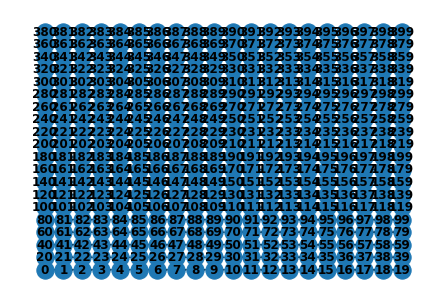

In [5]:
n = 20
edges, boundaries = square_lattice(n) 
G = FrequencyGraph(edges=edges, cz=cz)

pos = {i: (i%n, i//n) for i in range(n**2)}

G.plot(pos=pos)

In [6]:
len(edges)

800

In [10]:
N = 6

def tile_square_lattice(N,n, G, boundaries):
    """
    Tile the motif lattice G into a larger lattice of size N
    Arguments:
        N (int): size of the larger lattice NxN
        n (int): size of the motif nxn
        G (freqGraph): Motif lattice, with a solution
    Return:
        G_L: larger lattice with all frequency
    """
    
    
    freqs = {}
    anharms = {}
    drives = {}

    edges = []


    for node in range(N**2):

        # we need the position in the motif and in the lattice
        iL, jL = node%N, node//N
        i, ir = iL % n, iL // n
        j, jr = jL % n, jL // n

        node_r = i + j*n

        # assign the frequency
        freqs[node] = G.freqs[node_r] 
        anharms[node] = G.anharmonicity[node_r]

        # now we add the edges:
        for e in G.edges:

            drive = G.drive[e]
            control, target = e
            if control == node_r:

                i_target, j_target = target % n, target // n

                # for the bulk, its easy
                if e not in boundaries:

                    i_target += ir * n
                    j_target += jr * n
                    target = i_target + j_target * N

                    if (target < N**2) and (i_target<N):
                        edges.append((node, target))
                        drives[(node, target)] = drive

                # if we are in the boundary
                else:
                    x_extra, y_extra = boundaries[e]
                    i_target += ir * n - x_extra*n 
                    j_target += jr * n - y_extra*n 
                    target = i_target + j_target * N

                    if (target>=0) and (target < N**2) and (0<= i_target < N) and (0<=j_target< N):
                        edges.append((node, target))
                        drives[(node, target)] = drive
    G2 = FrequencyGraph(edges=edges, cz=cz)
    G2.set_values(freqs, anharms, drives)
    return G2

In [20]:
G2 = tile_square_lattice(N, n, G, boundaries)

The drive frequency are CR compatible


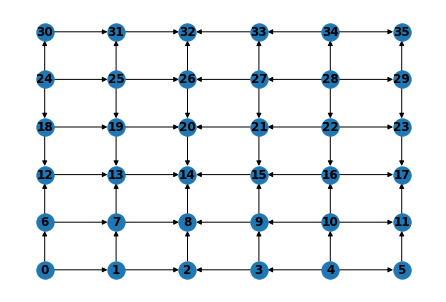

In [21]:
pos = {i: (i%N, i//N) for i in range(N**2)}
G2.plot(pos=pos)

## Optimization of the frequency

### optimization parameters

In [8]:
optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             qutrit=qutrit,
                             all_differents=all_differents)

### Optimization

In [9]:
# perform the optimization
optimizer.declare_solver()
result = optimizer.first_pass()
print("first pass done")
result = optimizer.second_pass()
print("second pass done")
result = optimizer.third_pass()

first pass done
second pass done


In [10]:
result

{'Problem': [{'Name': 'x191201', 'Lower bound': 1229.1415764029293, 'Upper bound': 1756.86758370619, 'Number of objectives': 1, 'Number of constraints': 34401, 'Number of variables': 21601, 'Number of binary variables': 12000, 'Number of integer variables': 12000, 'Number of continuous variables': 9601, 'Number of nonzeros': 132001, 'Sense': 'maximize'}], 'Solver': [{'Status': 'aborted', 'Return code': '0', 'Message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Termination condition': 'maxTimeLimit', 'Termination message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Wall time': '100.09211492538452', 'Error rc': 0, 'Time': 100.44478917121887}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Adding the results to the frequencyGraph

In [11]:
# # manually adding the frequencyes and the drives
# freqs = np.array([ 5.63, 5.55, 5.40, 5.25, 5.05, 5.15, 5.3, 5.43])
# freqs = np.array([ 5.794, 5.659, 5.478, 5.297, 5.115, 5.240, 5.421, 5.603])
# freqs = {k: freqs[k] for k in range(8)}
# anharms = {k: -0.310 for k in range(8)}
# drives =  {e: freqs[e[1]] for e in G.edges}

In [12]:
# drives

In [13]:
cz

False

In [14]:
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)
print(G.check_solution(d_dict, cstr=cstr_key))

The drive frequency are CR compatible
True


In [15]:
cstr_key

['A1', 'A2i', 'A2j', 'E1', 'E2', 'E4', 'C1', 'C1b', 'F1', 'F2', 'M1']

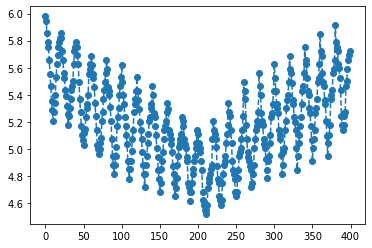

In [16]:
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')

## Yield of the design

Qubit collisions:
yield   = 0.9
average = 0.2


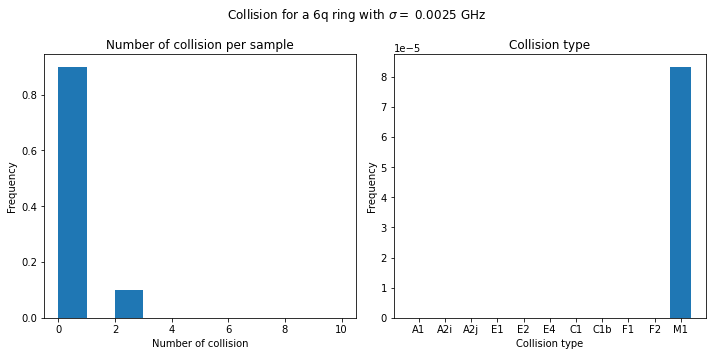

In [17]:
# parametrization
Nsamples = 10
sigma = 0.0025

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict, sigma=sigma, qutrit=False, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

### Collision type distribution

### Collision vs std of the frequencies

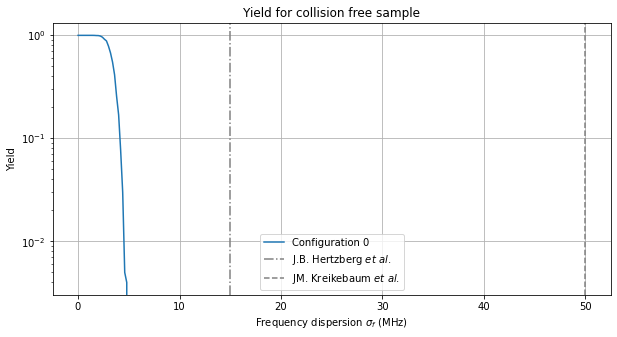

In [18]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 1000

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.01, 51)

# saving the results
collisions = np.array([G.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

# Transfering to larger lattice

cell size = 8
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
True
cell size = 10
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
True
cell size = 12
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
True
cell size = 14
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
True


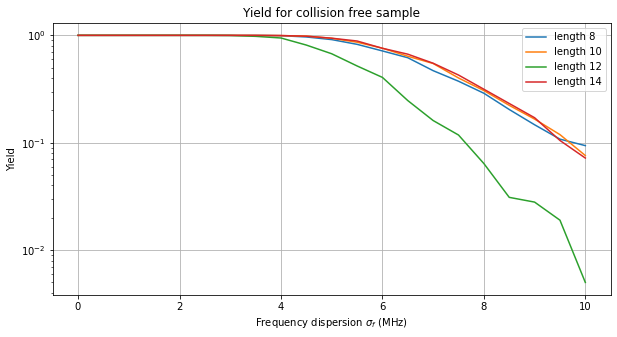

In [46]:
N_large = 50

n_vec = np.arange(4, 20, 2)

# N_samples
Nsamples = 1000

# varying the dispersion of the frequency
s_vec = list(np.linspace(0, 0.010, 21))
s_vec = np.array(s_vec)

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))


data = np.zeros((len(n_vec), len(s_vec)))
window = np.zeros((len(n_vec)))

for i_n, n in enumerate(n_vec):
    
    print(f"cell size = {n}")
    
    edges, boundaries = square_lattice(n)
    G = FrequencyGraph(edges=edges, cz=cz)

    optimizer = layout_optimizer(graph=G,
                                 architecture=architecture,
                                 qutrit=qutrit,
                                 all_differents=all_differents)

    # perform the optimization
    optimizer.declare_solver()
    result = optimizer.first_pass()
    print("first pass successfull")
    optimizer.second_pass()
    print("second pass successfull")
#     result = optimizer.third_pass()
#     print("third pass successfull")

    freqs, anharms, drives = optimizer.get_solution()
    G.set_values(freqs, anharms, drives)
    print(G.check_solution(d_dict, cstr=cstr_key))
    
    # calculate the window
    window[i_n] = max((list(freqs.values()))) - min(list(freqs.values()))
    
    ncell = n

    # frequency and anharmonicity are like the cell one, but with modulo
    G2 = tile_square_lattice(N, n, G, boundaries)
    print(G2.check_solution(d_dict, cstr=cstr_key))
    
    # saving the results
    collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

    n_collisions = [0]
    y = [(Nsamples-np.count_nonzero(collisions-nn, axis=1))/Nsamples for nn in n_collisions]
    data[i_n, :] = y[0]
    ax.plot(s_vec*1e3, y[0], label=f'length {n}')
    
    
# ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

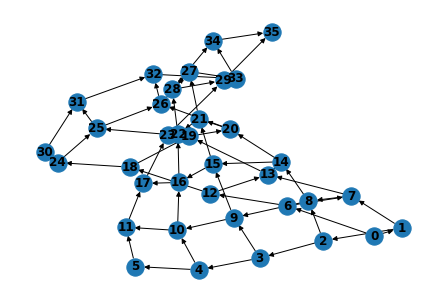

In [59]:
G2.plot()

In [48]:
res = np.zeros(len(n_vec))
for k in range(len(n_vec)):
    res[k] = None
    for i in range(len(s_vec)):
        if np.abs(data[k, i]-1)<1e-1:
            res[k] = i

In [49]:
res

array([10., 10.,  8., 10.])

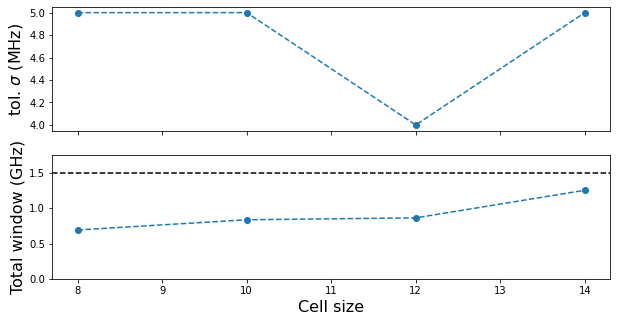

In [50]:
fig, ax = plt.subplots(2, sharex=True,  figsize=(10, 5))

ax[0].plot(n_vec, np.array([s_vec[int(r)] for r in res])*1e3, 'o--')
ax[1].plot(n_vec, window, 'o--')

ax[1].set_xlabel("Cell size", fontsize=16)
ax[0].set_ylabel("tol. $\sigma$ (MHz)", fontsize=16)
ax[1].set_ylabel("Total window (GHz)", fontsize=16)
# ax[0].set_ylim(0, 16)
ax[1].set_ylim(0, 1.75)

ax[1].axhline(1.5, color='k', ls='--')

# ax[0].set_ylim(10, 12)
fig.savefig("scaling_ring.pdf")

In [170]:
n_vec

array([ 4,  8, 12, 16, 20, 24])

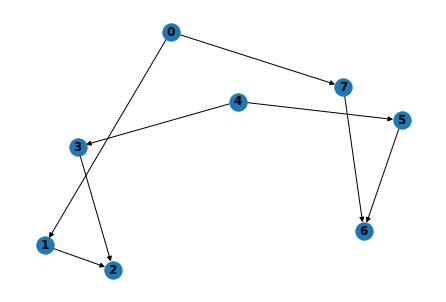

In [58]:
G2 = FrequencyGraph(edges=edges, cz=cz)
G2.plot()

In [85]:
# # manually adding the frequencyes and the drives 
freqs = {k: G.freqs[k] for k in range(4)}
anharms = {k: G.anharmonicity[k] for k in range(4)} 
drives =  {e: freqs[e[1]] for e in G.edges}

In [86]:
for k in range(4):
    freqs[k+4] = freqs[k]

In [87]:
for k in range(4):
    anharms[k+4] = anharms[k]

In [88]:
exceptional_edge = (0,3)

# add the new edges:
from copy import deepcopy
new_drives = deepcopy(drives)
for k in drives.keys():
    if k not in exceptional_edge:
        i, j = k
        new_drives[( (i+4)%8, (j+4)%8)] = drives[(i, j)]    
# change the 0 of the (0,3) edge
new_drives[(4,3)] = drives[(0, 3)]
new_drives[(0,7)] = drives[(0, 3)]
new_drives.pop((0,3), None)
new_drives.pop((4,7), None)

4.575

In [89]:
new_drives

{(0, 1): 4.63,
 (1, 2): 4.52,
 (3, 2): 4.52,
 (4, 5): 4.63,
 (5, 6): 4.52,
 (7, 6): 4.52,
 (4, 3): 4.575,
 (0, 7): 4.575}

In [93]:
drives

{(0, 1): 4.63, (0, 3): 4.575, (1, 2): 4.52, (3, 2): 4.52}

The drive frequency are CR compatible
True


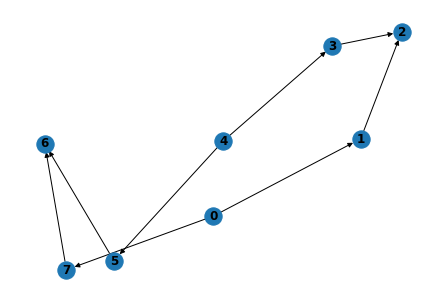

In [95]:
G2 = FrequencyGraph(edges=list(new_drives.keys()), cz=cz)
G2.plot()
G2.set_values(freqs, anharms, new_drives)
print(G2.check_solution(d_dict, cstr=cstr_key))

Qubit collisions:
yield   = 0.06132
average = 4.01872


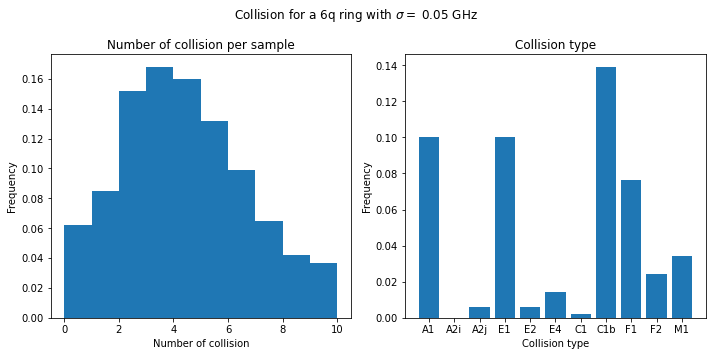

In [96]:
# parametrization
Nsamples = 50000
sigma = 0.05

# Calculating yield
collisions, c, idx_list, constraints = G2.get_collision(d_dict, sigma=sigma, qutrit=False, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

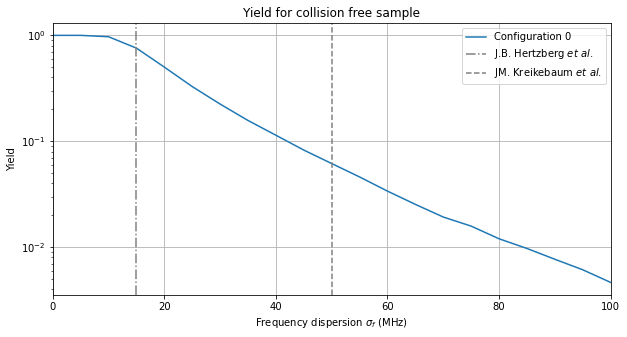

In [102]:
# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 100000

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.1, 21)

# saving the results
collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

ax.set_xlim(0, 100)
ax.grid()

In [103]:
data = {"sigma": s_vec, 
        "collisions": collisions,
        "key": cstr_key,
        "yield": y,
        "samples":Nsamples}
np.save(f'ring_8t_{architecture}_yield_2x4.npy',data)

In [104]:
data_CR = np.load('ring_8t_CR_yield.npy', allow_pickle=True)[()]

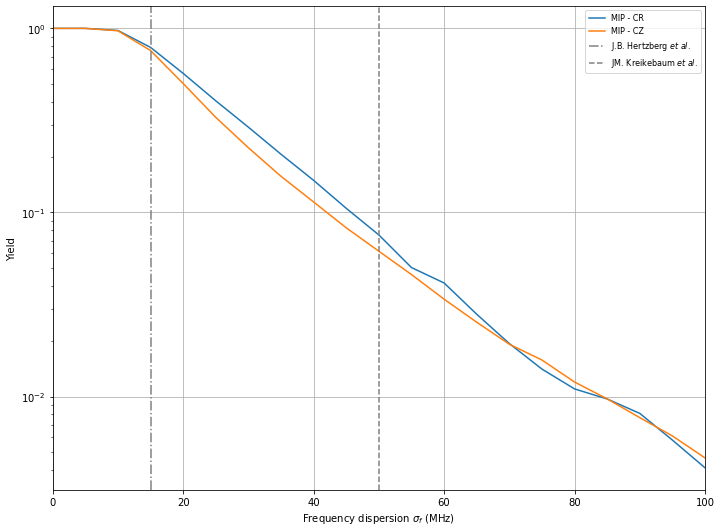

In [105]:
fig, ax = plt.subplots(figsize=(3*3.375, 3*2.5))


s_vec_cr = data_CR["sigma"]
y_cr = data_CR["yield"]

s_vec_cz = data["sigma"]
y_cz = data["yield"]



ax.plot(s_vec_cr*1e3, y_cr[0], label=f'MIP - CR')
ax.plot(s_vec_cz*1e3, y_cz[0], label=f'MIP - CZ')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
# ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=8, loc=0)

ax.set_xlim(0, 100)
ax.grid()

fig.tight_layout()

# fig.savefig("fig_yield_ring.pdf")

In [152]:
G.nodes['A'] = 'C'

TypeError: 'NodeView' object does not support item assignment